In [1]:
import torch
from torch import nn

In [2]:
t = torch.randn(1,2,3)
print(t.shape)
t, t.permute(2,0,1)
for x in t.permute(2,0,1):
    print(x.shape)

torch.Size([1, 2, 3])
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1, 2])


In [3]:
from d2l_common import AttentionDecoder, AdditiveAttention, init_seq2seq


class Seq2SeqAttentionDecoder(AttentionDecoder):
    
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.dropout = dropout
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # shape of outputs: (num_steps, batch_size, num_hiddens)
        # shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # shape of outputs: (num_steps, batch_size, num_hiddens)
        # shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # shape of X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1,0,2)
        outputs, self._attention_weights = [], []
        for x in X:
            # shape of query: (batch_size, 1, num_hiddens)
            query = hidden_state[-1].unsqueeze(1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, x.unsqueeze(1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            # shape of out: (1, batch_size, embed_size + num_hiddens)
            outputs.append(out)
            self._attention_weights.append(self.attention.attn_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        # shape of outputs: (num_steps, batch_size, vocab_size)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights
        

In [4]:
from d2l_common import Encoder, Decoder, Seq2SeqEncoder

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7

encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)

X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)

output, state = decoder(X, state)
print(output.shape)
print(state[0].shape)
print(state[1].shape)
assert output.shape == (batch_size, num_steps, vocab_size)
assert state[0].shape == (batch_size, num_steps, num_hiddens)
assert state[1].shape == (num_layers, batch_size, num_hiddens)

torch.Size([4, 7, 10])
torch.Size([4, 7, 16])
torch.Size([2, 4, 16])


/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
from d2l_common import MTFraEng, Seq2Seq, Trainer

data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

model = Seq2Seq(encoder, decoder, tgt_pad = data.tgt_vocab['<pad>'], lr=0.005)
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

complete 0 epoch train_loss=0.30055803060531616 validate_loss=0.05756046995520592
complete 1 epoch train_loss=0.006916724145412445 validate_loss=0.00464285584166646
complete 2 epoch train_loss=0.0016251601045951247 validate_loss=0.0010228720493614674
complete 3 epoch train_loss=0.0004075857868883759 validate_loss=0.000259631808148697
complete 4 epoch train_loss=0.0001241763966390863 validate_loss=8.813948079477996e-05
complete 5 epoch train_loss=5.2343639254104346e-05 validate_loss=4.0776423702482134e-05
complete 6 epoch train_loss=2.815144216583576e-05 validate_loss=2.340382525289897e-05
complete 7 epoch train_loss=1.8128021110896952e-05 validate_loss=1.55939760588808e-05
complete 8 epoch train_loss=1.2964647794433404e-05 validate_loss=1.156357757281512e-05
complete 9 epoch train_loss=1.014115878206212e-05 validate_loss=9.279693585995119e-06
complete 10 epoch train_loss=8.54008067108225e-06 validate_loss=7.880139492044691e-06
complete 11 epoch train_loss=7.477910457964754e-06 validate

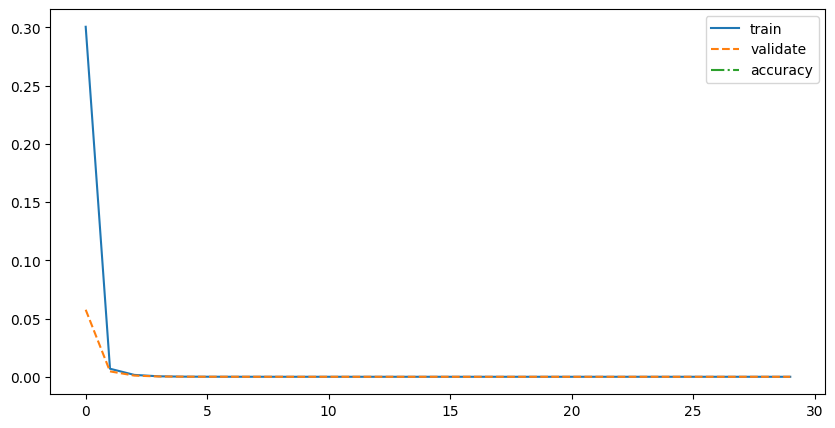

In [6]:
trainer.plot()

In [7]:
from d2l_common import bleu

engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), 'cpu', data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['défaits', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i lost . => ['défaits', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
he's calm . => ['défaits', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000
i'm home . => ['défaits', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], bleu,0.000


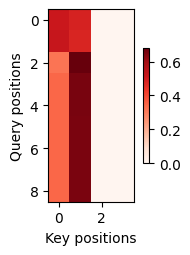

In [8]:
from d2l_common import show_heatmaps

_, dec_attention_weights = model.predict_step(data.build(engs[-1],[fras[-1]]), 'cpu', data.num_steps, True)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weights],dim=0)
attention_weights = attention_weights.view((1,1,-1,data.num_steps))

show_heatmaps(attention_weights[:,:,:,:len(engs[-1].split())+1].cpu(), xlabel='Key positions', ylabel='Query positions')

